We are going to scrap the pib table from [this wikipedia article]("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal))
using the requests and beautiful soup librairies.

Later on, we will load other data sources with pandas, and use the regex librairy re.

pyplot will be used for adjusting pandas' plotting options.

In [1]:
import requests
import bs4
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

These two functions are designed to extract the contents of interest out of the table data cell from the wikipedia table

In [2]:
def extract_number(cell):
    try :
        return re.findall(r'[0-9]*', cell.contents[0].replace(",",''))[0]
    except :
        return 
    
def extract_country(cell):
        try :
            return cell.contents[1].contents[0]
        except : 
            return 

Let's load our additional datasets and normalize the country name column.

In [3]:
countries_geo=pd.read_csv("./datasets/Country_List_ISO_3166_Codes_Latitude_Longitude.csv")
country_data=pd.read_excel('./datasets/Countries of the world.xls', header=2)
country_units= country_data.loc[0]
country_data=country_data[1:]
country_data['n_country'] = country_data.Country.apply(lambda n: n.lower().replace(" ",""))


Ok, let's extract the table from Wikipedia:

In [4]:
doc = requests.get("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)").content
bdoc=bs4.BeautifulSoup(doc)
tables =bdoc.find_all('table')

table=tables[2]
trs= table.find_all('tr')
rdatae=[tr.find_all('td') for tr in trs]
countries= []
pibs = []
for row in rdatae[2:]:
    pib = extract_number(row[2])
    country = extract_country(row[1])
    countries.append(country)
    pibs.append(pib)

And here is the dataframe:

In [5]:
country_pib=pd.DataFrame(list(zip(countries, pibs)), columns=['country', 'pib'])
country_pib['n_country']=country_pib.country.apply(lambda n: (n or '').lower().replace(" ",""))

Some renamings and preprocessing

In [6]:
countries_geoloc=countries_geo[['Country', 'Latitude (average)', 'Longitude (average)', 'Alpha-2 code']].rename({'Latitude (average)': 'lat', 'Longitude (average)': 'lon', 'Alpha-2 code': "code"}, axis=1)
countries_geoloc['n_country']=countries_geoloc.Country.apply(lambda n: (n or '').lower().replace(" ",""))

Alright, let's merge our datasources !

In [7]:
country_data=country_pib.merge(country_data, on='n_country').merge(countries_geoloc[['n_country', 'lat','lon','code']], on='n_country')
country_data.pib = country_data.pib.astype(int)

And compute the PIB to population ratio

In [8]:
country_data['pib_per_pop'] = country_data.pib/country_data.Population

In [9]:
#country_data.to_csv("./datasets/country_data.csv")


In order to see which countries have the highest PIB by regions, we'll use pandas' groupby function

In [10]:
regional=country_data.groupby(['Region'])

This function generates a DataFrameGroupBy object that can to be aggregated.

In [11]:
regional

The aggregate or agg method takes a function of a dataframe. 
The dataframe that will be passed to this function is the subdataframe inside the groups.
For instance, if we want to recover the line with the highest pib, we can 
- first get its index with the idxmax function
- then recover the whole line with the loc function

In [12]:
getmaxpib= lambda df: df.loc[df.pib.idxmax()]
getminpib= lambda df: df.loc[df.pib.idxmin()]

In [20]:
maxregional = regional.apply(getmaxpib)
minregional = regional.apply(getminpib)

In [21]:
maxregional

,country,pib,n_country,Country,Region,Population,Area,Pop. Density,Coastline,Net migration,...,Birthrate,Deathrate,Agriculture,Industry,Service,lat,lon,code,pib_per_pop,A
Region,,,,,,,,,,,,,,,,,,,,,
ASIA (EX. NEAR EAST),China,12014610,china,China,ASIA (EX. NEAR EAST),1.313974e+09,9596960,136.92,0.15,-0.40,...,13.25,6.97,0.125,0.473,0.403,35.0,105.0,CN,0.009144,1
BALTICS,Lithuania,47263,lithuania,Lithuania,BALTICS,3.585906e+06,65200,55.00,0.14,-0.71,...,8.75,10.98,0.055,0.325,0.620,56.0,24.0,LT,0.013180,1
C.W. OF IND. STATES,Kazakhstan,160839,kazakhstan,Kazakhstan,C.W. OF IND. STATES,1.523324e+07,2717300,5.61,0.00,-3.35,...,16.00,9.42,0.067,0.386,0.547,48.0,68.0,KZ,0.010558,1
EASTERN EUROPE,Poland,524886,poland,Poland,EASTERN EUROPE,3.853687e+07,312685,123.25,0.16,-0.49,...,9.85,9.89,0.050,0.311,0.640,52.0,20.0,PL,0.013620,1
LATIN AMER. & CARIB,Brazil,2054969,brazil,Brazil,LATIN AMER. & CARIB,1.880782e+08,8511965,22.10,0.09,-0.03,...,16.56,6.17,0.084,0.400,0.516,-10.0,-55.0,BR,0.010926,1
NEAR EAST,Turkey,849480,turkey,Turkey,NEAR EAST,7.041396e+07,780580,90.21,0.92,0.00,...,16.62,5.97,0.117,0.298,0.585,39.0,35.0,TR,0.012064,1
NORTHERN AFRICA,Egypt,237073,egypt,Egypt,NORTHERN AFRICA,7.888701e+07,1001450,78.77,0.24,-0.22,...,22.94,5.23,0.149,0.357,0.493,27.0,30.0,EG,0.003005,1
NORTHERN AMERICA,United States,19390600,unitedstates,United States,NORTHERN AMERICA,2.984442e+08,9631420,30.99,0.21,3.41,...,14.14,8.26,0.010,0.204,0.787,38.0,-97.0,US,0.064972,1
OCEANIA,Australia,1379548,australia,Australia,OCEANIA,2.026408e+07,7686850,2.64,0.34,3.98,...,12.14,7.51,0.038,0.262,0.700,-27.0,133.0,AU,0.068078,1


In [22]:
minregional

,country,pib,n_country,Country,Region,Population,Area,Pop. Density,Coastline,Net migration,...,Birthrate,Deathrate,Agriculture,Industry,Service,lat,lon,code,pib_per_pop,A
Region,,,,,,,,,,,,,,,,,,,,,
ASIA (EX. NEAR EAST),Bhutan,2321,bhutan,Bhutan,ASIA (EX. NEAR EAST),2279723.0,47000,48.50,0.00,0.00,...,33.65,12.70,0.258,0.379,0.363,27.5000,90.5000,BT,0.001018,0
BALTICS,Estonia,25973,estonia,Estonia,BALTICS,1324333.0,45226,29.28,8.39,-3.16,...,10.04,13.25,0.040,0.294,0.666,59.0000,26.0000,EE,0.019612,0
C.W. OF IND. STATES,Kyrgyzstan,7061,kyrgyzstan,Kyrgyzstan,C.W. OF IND. STATES,5213898.0,198500,26.27,0.00,-2.45,...,22.80,7.08,0.353,0.208,0.439,41.0000,75.0000,KG,0.001354,0
EASTERN EUROPE,Albania,13001,albania,Albania,EASTERN EUROPE,3581655.0,28748,124.59,1.26,-4.93,...,15.11,5.22,0.232,0.188,0.579,41.0000,20.0000,AL,0.003630,0
LATIN AMER. & CARIB,Dominica,608,dominica,Dominica,LATIN AMER. & CARIB,68910.0,754,91.39,19.63,-13.87,...,15.27,6.73,0.177,0.328,0.495,15.4167,-61.3333,DM,0.008823,0
NEAR EAST,Yemen,16511,yemen,Yemen,NEAR EAST,21456188.0,527970,40.64,0.36,0.00,...,42.89,8.30,0.135,0.472,0.393,15.0000,48.0000,YE,0.000770,0
NORTHERN AFRICA,Tunisia,40275,tunisia,Tunisia,NORTHERN AFRICA,10175014.0,163610,62.19,0.70,-0.57,...,15.52,5.13,0.132,0.318,0.550,34.0000,9.0000,TN,0.003958,0
NORTHERN AMERICA,Canada,1652412,canada,Canada,NORTHERN AMERICA,33098932.0,9984670,3.31,2.02,5.96,...,10.78,7.80,0.022,0.294,0.684,60.0000,-95.0000,CA,0.049923,1
OCEANIA,Tuvalu,40,tuvalu,Tuvalu,OCEANIA,11810.0,26,454.23,92.31,0.00,...,22.18,7.11,0.166,0.272,0.562,-8.0000,178.0000,TV,0.003387,0


We could have reached the same result with aggregate, but it doesn't work on multiple grouping columns

In [25]:

try:
    country_data['A']=country_data.pib.apply(lambda x: int(x>country_data.pib.median()))
    regional2 = country_data.groupby(['A', 'Region'])
    regional2.aggregate(getmaxpib)
except AttributeError: 
    print("Doesn't work...")
 

Doesn't work...


In [26]:
country_data['A']=country_data.pib.apply(lambda x: int(x>country_data.pib.median()))
regional2 = country_data.groupby(['A', 'Region'])
regional2.apply(getmaxpib)

country       pib  \
A Region                                                            
0 ASIA (EX. NEAR EAST)                            Nepal     24472   
  BALTICS                                        Latvia     30319   
  C.W. OF IND. STATES                        Azerbaijan     40670   
  EASTERN EUROPE                                 Serbia     41471   
  LATIN AMER. & CARIB                          Paraguay     29619   
  NEAR EAST                                      Jordan     40487   
  NORTHERN AFRICA                               Tunisia     40275   
  OCEANIA                              Papua New Guinea     23617   
  SUB-SAHARAN AFRICA                           Cameroon     34006   
  WESTERN EUROPE                                Iceland     23909   
1 ASIA (EX. NEAR EAST)                            China  12014610   
  BALTICS                                     Lithuania     47263   
  C.W. OF IND. STATES                        Kazakhstan    160839   
  EASTERN EUROPE                                 Poland    524886   
  LATIN AMER. & CARIB                            Brazil   2054969   
  NEAR EAST                                      Turkey    849480   
  NORTHERN AFRICA                                 Egypt    237073   
  NORTHERN AMERICA                        United States  19390600   
  OCEANIA                                     Australia   1379548   
  SUB-SAHARAN AFRICA                            Nigeria    376284   
  WESTERN EUROPE                                Germany   3684816   

                                            n_country            Country  \
A Region                                                                   
0 ASIA (EX. NEAR EAST)                          nepal             Nepal    
  BALTICS                                      latvia            Latvia    
  C.W. OF IND. STATES                      azerbaijan        Azerbaijan    
  EASTERN EUROPE                               serbia            Serbia    
  LATIN AMER. & CARIB                        paraguay          Paraguay    
  NEAR EAST                                    jordan            Jordan    
  NORTHERN AFRICA                             tunisia           Tunisia    
  OCEANIA                              papuanewguinea  Papua New Guinea    
  SUB-SAHARAN AFRICA                         cameroon          Cameroon    
  WESTERN EUROPE                              iceland           Iceland    
1 ASIA (EX. NEAR EAST)                          china             China    
  BALTICS                                   lithuania         Lithuania    
  C.W. OF IND. STATES                      kazakhstan        Kazakhstan    
  EASTERN EUROPE                               poland            Poland    
  LATIN AMER. & CARIB                          brazil            Brazil    
  NEAR EAST                                    turkey            Turkey    
  NORTHERN AFRICA                               egypt             Egypt    
  NORTHERN AMERICA                       unitedstates     United States    
  OCEANIA                                   australia         Australia    
  SUB-SAHARAN AFRICA                          nigeria           Nigeria    
  WESTERN EUROPE                              germany           Germany    

                                                                    Region  \
A Region                                                                     
0 ASIA (EX. NEAR EAST)                       ASIA (EX. NEAR EAST)            
  BALTICS                              BALTICS                               
  C.W. OF IND. STATES                                 C.W. OF IND. STATES    
  EASTERN EUROPE                       EASTERN EUROPE                        
  LATIN AMER. & CARIB                              LATIN AMER. & CARIB       
  NEAR EAST                            NEAR EAST                             
  NORTHERN AFRICA                      NORTHERN AFRICA                       
  OCEANIA

In [27]:
country_data.drop('A', axis=1, inplace=True)

# Quick look at the data

First let's do some type casting

In [28]:
numeric=[]
labelcols=[]
for c in country_data.columns:
    try:
        country_data[c]= country_data[c].astype(float)
        numeric.append(c)
    except:
        labelcols.append(c)
        print(c)

country
n_country
Country
Region
code


And see the various correlations between these geoeconomic variables

In [29]:
country_data.corr()

,pib,Population,Area,Pop. Density,Coastline,Net migration,Infant mortality,GDP,Literacy,Phones,...,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service,lat,lon,pib_per_pop
pib,1.000000,0.585281,0.664577,-0.009928,-0.054350,0.090515,-0.162823,0.300562,0.141696,0.377625,...,-0.026040,0.123084,-0.196199,-0.076558,-0.176699,0.015031,0.152748,0.145794,-0.050556,0.178400
Population,0.585281,1.000000,0.541889,-0.006507,-0.064522,0.007337,-0.008093,-0.030038,-0.031969,0.018676,...,-0.132802,-0.028233,-0.072808,-0.071548,-0.020922,0.082831,-0.052318,0.052401,0.117903,-0.050935
Area,0.664577,0.541889,1.000000,-0.084613,-0.100425,0.098476,-0.049416,0.146105,0.046394,0.188101,...,0.154346,-0.098420,-0.091731,-0.061232,-0.097013,0.091257,0.011406,-0.013489,-0.074778,0.074103
Pop. Density,-0.009928,-0.006507,-0.084613,1.000000,0.199711,0.229506,-0.147206,0.205609,0.080480,0.194969,...,-0.001702,-0.018693,-0.172494,-0.140670,-0.149079,-0.106591,0.233659,-0.013190,0.170469,0.184508
Coastline,-0.054350,-0.064522,-0.100425,0.199711,1.000000,0.005808,-0.101505,-0.017614,0.091471,0.057383,...,-0.072165,-0.033179,-0.038550,-0.141165,-0.095388,-0.174380,0.243632,-0.119412,0.223608,-0.002184
Net migration,0.090515,0.007337,0.098476,0.229506,0.005808,1.000000,-0.013770,0.436426,-0.025500,0.271901,...,0.162230,-0.100070,-0.068991,0.063419,-0.122534,0.082286,0.041016,0.155491,0.218070,0.495238
Infant mortality,-0.162823,-0.008093,-0.049416,-0.147206,-0.101505,-0.013770,1.000000,-0.606174,-0.753782,-0.689352,...,0.174615,-0.399687,0.853088,0.639614,0.694195,-0.029812,-0.617187,-0.343652,0.080442,-0.449051
GDP,0.300562,-0.030038,0.146105,0.205609,-0.017614,0.436426,-0.606174,1.000000,0.517687,0.888495,...,0.021134,0.395471,-0.654977,-0.196393,-0.618616,0.031047,0.549618,0.454468,-0.055180,0.823914
Literacy,0.141696,-0.031969,0.046394,0.080480,0.091471,-0.025500,-0.753782,0.517687,1.000000,0.614851,...,-0.138223,0.417040,-0.785761,-0.347076,-0.606917,0.060948,0.502351,0.277117,-0.072507,0.351064
Phones,0.377625,0.018676,0.188101,0.194969,0.057383,0.271901,-0.689352,0.888495,0.614851,1.000000,...,-0.093040,0.493071,-0.756892,-0.247732,-0.638392,-0.030892,0.625791,0.504975,-0.102196,0.683325


# Dimensional reduction

In [30]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [31]:
pipeline= Pipeline([
    ('imputer', Imputer()),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

In [32]:
labels = country_data.country.values
Xvalues= country_data[numeric].drop('pib', axis=1).values


In [33]:
pipeline.fit(Xvalues)
pcastep = pipeline.named_steps['pca']


In [34]:
imputer_strategy=['mean', 'median', 'most_frequent']
pca_n_components = list(range(2,10))
grid= GridSearchCV(pipeline, {'imputer__strategy': imputer_strategy,
                              'pca__n_components':pca_n_components
                             })

Best imputer strategy: mean
Best PCA n_components: 2


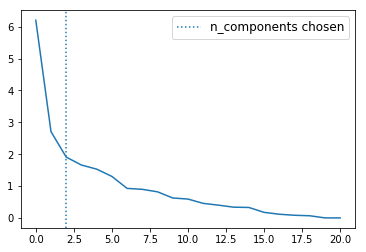

In [35]:
grid.fit(Xvalues)
best_est=grid.best_estimator_
print('Best imputer strategy: {}\nBest PCA n_components: {}'.format(best_est.named_steps['imputer'].strategy, best_est.named_steps['pca'].n_components))
plt.plot(pcastep.explained_variance_)
plt.axvline(grid.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))


In [36]:
steps= grid.best_estimator_.steps + [('kmeans', KMeans())]
classifier = Pipeline(steps)


In [37]:
classifier_grid = GridSearchCV(classifier,{
                                            'kmeans__n_clusters': [3,4,5,6]
                                            },n_jobs=-1)

In [38]:
classifier_grid.fit(Xvalues)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='..., n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kmeans__n_clusters': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
bestpca= grid.best_estimator_.named_steps['pca']
pd.DataFrame([dict(zip(numeric,comp)) for comp in bestpca.components_]).T

,0,1
Agriculture,0.009091,0.262320
Arable,-0.023231,-0.371595
Area,0.092989,0.041249
Birthrate,-0.181267,0.063198
Climate,-0.361634,0.042535
Coastline,0.090593,0.312107
Crops,-0.068968,0.514220
Deathrate,-0.312297,-0.105583
GDP,0.308548,-0.073968
Industry,0.282392,-0.133908


In [40]:
Xtrans = grid.transform(Xvalues)


In [41]:
print (classifier_grid.best_estimator_.named_steps['kmeans'].n_clusters)
Xclass = classifier_grid.predict(Xvalues)

6


In [42]:
clusters ={}
for xy, k in zip(Xtrans, Xclass):
    clusters.update({k:clusters.get(k,[])+[xy]})

In [43]:
tolist= lambda df:', '.join(df.map(lambda s: s.replace("  ", "").strip()).unique())
tolist(country_data.Region)

'NORTHERN AMERICA, ASIA (EX. NEAR EAST), WESTERN EUROPE, LATIN AMER. & CARIB, OCEANIA, NEAR EAST, EASTERN EUROPE, SUB-SAHARAN AFRICA, NORTHERN AFRICA, C.W. OF IND. STATES, BALTICS'

In [44]:
country_data['class'] = Xclass
country_data.groupby("class").agg({'Region':tolist, 'lat':'mean', 'lon': 'mean'})

,Region,lat,lon
class,,,
0,"ASIA (EX. NEAR EAST), NEAR EAST, EASTERN EUROP...",21.173336,31.318664
1,"SUB-SAHARAN AFRICA, ASIA (EX. NEAR EAST), NEAR...",5.531250,37.750000
2,"NORTHERN AMERICA, OCEANIA, WESTERN EUROPE, NEA...",38.748181,22.716137
3,"ASIA (EX. NEAR EAST), SUB-SAHARAN AFRICA, LATI...",1.597225,12.222225
4,"ASIA (EX. NEAR EAST), LATIN AMER. & CARIB, NEA...",11.074324,1.014865
5,"ASIA (EX. NEAR EAST), WESTERN EUROPE, EASTERN ...",42.336419,22.526541


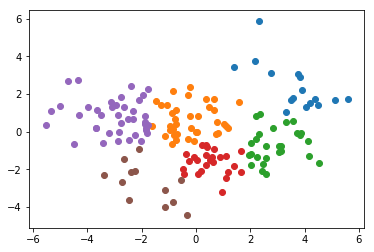

In [45]:
for xfit in clusters.values():
    plt.scatter([xy[0] for xy in xfit], [xy[1] for xy in xfit])

In [46]:
country_data_clusters=country_data.set_index(['class', 'Region', 'country']).sort_index()

In [47]:
country_data_clusters.loc[4]

pib     n_country  \
Region                              country                                  
ASIA (EX. NEAR EAST)                China         12014610.0         china   
                                    Indonesia      1015411.0     indonesia   
                                    Malaysia        314497.0      malaysia   
                                    Mongolia         10869.0      mongolia   
                                    Vietnam         220408.0       vietnam   
C.W. OF IND. STATES                 Azerbaijan       40670.0    azerbaijan   
                                    Kazakhstan      160839.0    kazakhstan   
                                    Kyrgyzstan        7061.0    kyrgyzstan   
                                    Turkmenistan     37926.0  turkmenistan   
                                    Uzbekistan       47883.0    uzbekistan   
LATIN AMER. & CARIB                 Argentina       637717.0     argentina   
                                    Belize            1819.0        belize   
                                    Brazil         2054969.0        brazil   
                                    Chile           277042.0         chile   
                                    Colombia        309197.0      colombia   
                                    Costa Rica       58056.0     costarica   
                                    Ecuador         102311.0       ecuador   
                                    Guatemala        75661.0     guatemala   
                                    Guyana            3591.0        guyana   
                                    Honduras         22975.0      honduras   
                                    Mexico         1149236.0        mexico   
                                    Nicaragua        13692.0     nicaragua   
                                    Panama           61838.0        panama   
                                    Paraguay         29619.0      paraguay   
                                    Peru            215224.0          peru   
                                    Suriname          3665.0      suriname   
                                    Uruguay          58415.0       uruguay   
NEAR EAST                           Bahrain          34895.0       bahrain   
                                    Jordan           40487.0        jordan   
                                    Oman             74274.0          oman   
                                    Saudi Arabia    683827.0   saudiarabia   
NORTHERN AFRICA                     Algeria         178287.0       algeria   
                                    Egypt           237073.0         egypt   
                                    Morocco         109824.0       morocco   
OCEANIA                             Tuvalu              40.0        tuvalu   
SUB-SAHARAN AFRICA                  Namibia          12558.0       namibia   
                                    South Africa    349299.0   southafrica   

                                                        Country    Population  \
Region                              country                                     
ASIA (EX. NEAR EAST)                China                China   1.313974e+09   
                                    Indonesia        Indonesia   2.454527e+08   
                                    Malaysia          Malaysia   2.438586e+07   
                                    Mongolia          Mongolia   2.832224e+06   
                                    Vietnam            Vietnam   8.440297e+07   
C.W. OF IND. STATES                 Azerbaijan      Azerbaijan   7.961619e+06   
                                    Kazakhstan      Kazakhstan   1.523324e+07   
                                    Kyrgyzstan      Kyrgyzstan   5.213898e+06   
                                    Turkmenistan  Turkmenistan   5.042920e+06   
                                    Uzbekistan      Uzbekistan   2.730713e+07   
LATIN AMER. & CARIB                 Argent